### I. Import Libraries

In [5]:
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

In [52]:
#!pip freeze > requirements.txt

### II. Import and Examine Dataset

There are 211,727 data points and no missing values. The classes are very imbalanced.
- NN is the most frequent POS tag (30,147 occurrences). SYM is the least frequent (six occurrences). 
- I-NP is the most frequent chunk tag (63,307 occurrences). B-UCP and I-PRT are the least frequent (two occurrences each).

In [6]:
chunking_data = 'Datasets/chunking_dataset.txt'
df = pd.read_csv(chunking_data, sep=' ', header=None)
df.columns = ['token', 'pos_tag', 'chunk_tag']
df.head()

,token,pos_tag,chunk_tag
0,Confidence,NN,B-NP
1,in,IN,B-PP
2,the,DT,B-NP
3,pound,NN,I-NP
4,is,VBZ,B-VP


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211727 entries, 0 to 211726
Data columns (total 3 columns):
token        211727 non-null object
pos_tag      211727 non-null object
chunk_tag    211727 non-null object
dtypes: object(3)
memory usage: 4.8+ MB


In [47]:
df.pos_tag.value_counts()

NN      30147
IN      22764
NNP     19884
DT      18335
NNS     13619
JJ      13085
,       10770
.       8827 
CD      8315 
VBD     6745 
RB      6607 
VB      6017 
CC      5372 
TO      5081 
VBN     4763 
VBZ     4648 
PRP     3820 
VBG     3272 
VBP     2868 
MD      2167 
PRP$    1881 
POS     1769 
$       1750 
``      1531 
''      1493 
:       1047 
WDT     955  
JJR     853  
WP      529  
WRB     478  
NNPS    420  
JJS     374  
RBR     321  
)       281  
(       274  
EX      206  
RBS     191  
RP      83   
PDT     55   
FW      38   
#       36   
WP$     35   
UH      15   
SYM     6    
Name: pos_tag, dtype: int64

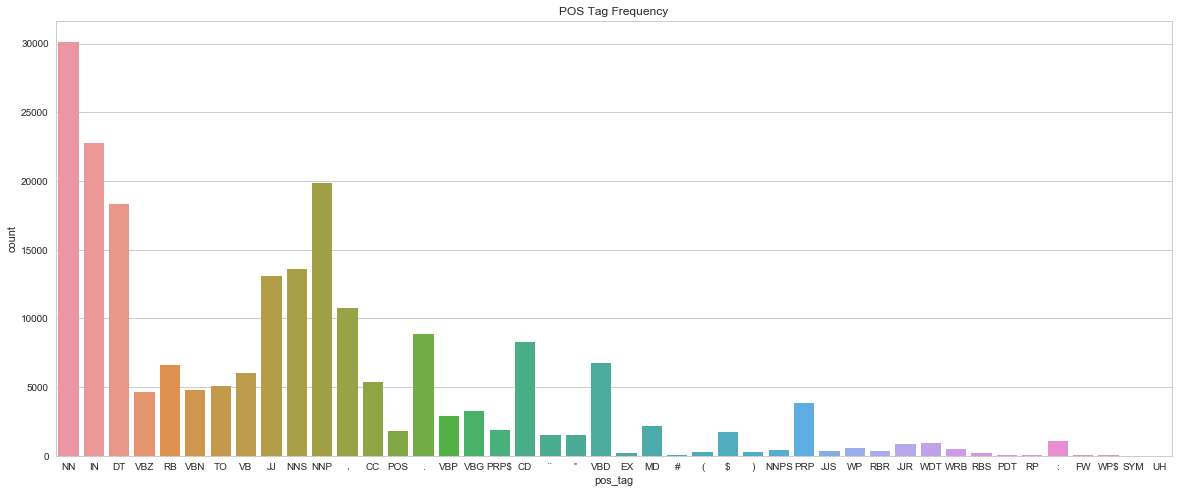

In [5]:
fig = plt.figure(figsize=(20,8))
plt.title('POS Tag Frequency')
sns.countplot(data=df, x='pos_tag');

In [6]:
df.chunk_tag.value_counts()

I-NP       63307
B-NP       55081
O          27902
B-VP       21467
B-PP       21281
I-VP       12003
B-ADVP     4227 
B-SBAR     2207 
B-ADJP     2060 
I-ADJP     643  
B-PRT      556  
I-ADVP     443  
I-PP       291  
I-CONJP    73   
I-SBAR     70   
B-CONJP    56   
B-INTJ     31   
B-LST      10   
I-INTJ     9    
I-UCP      6    
I-PRT      2    
B-UCP      2    
Name: chunk_tag, dtype: int64

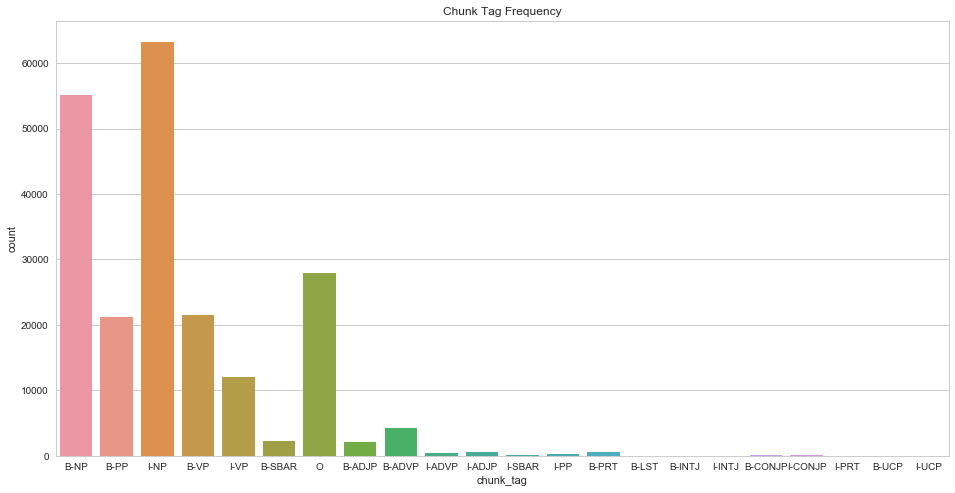

In [7]:
fig = plt.figure(figsize=(16,8))
plt.title('Chunk Tag Frequency')
sns.countplot(data=df, x='chunk_tag');

Examine tokens labelled as each of the chunk tags to understand their characteristics. This is important for feature engineering.

In [23]:
df[df.chunk_tag=='B-CONJP']

,token,pos_tag,chunk_tag
4924,Not,RB,B-CONJP
6498,as,RB,B-CONJP
7364,as,RB,B-CONJP
7788,if,IN,B-CONJP
16631,not,RB,B-CONJP
16642,but,CC,B-CONJP
26011,along,IN,B-CONJP
26952,as,RB,B-CONJP
28668,if,IN,B-CONJP
31172,as,RB,B-CONJP


### III. Feature Engineering and Prepare Training and Validation Sets

A baseline model would only have tokens and POS tags as input features, and would select the chunk tag most frequently associated with each POS tag (tokens are needed to predict the POS tags).

The more sophisticated approach adopted here considers the *context* of each token: the words preceding and following it, as well as their POS tags. This makes linguistic sense - articles such as 'the' and 'a' come before nouns and form chunks with them; 'to' often comes before verbs. Thus, context also allows for distinctions to be drawn between [words that can be verbs and nouns](https://www.enchantedlearning.com/wordlist/nounandverb.shtml).

Different combinations of features were tested and validated with the Decision Tree classifier, as it is arguably the most transparent. To save time, the classifier was tested on only 10,000 tokens. Apart from tokens and POS tags, stemming (a non-lexicographical representation of the root form of a word), capitalisation, and tokens up to two indices before or after were considered, along with their POS tags. The previous chunk tag was also added.
 
Here are the mean F1 scores:
- token, POS: 0.7892409455950302
- token, stem, POS: 0.7894436549142528
- token, POS, previous token/POS: 0.9072529562030741
- token, POS, previous token/POS, next token/POS: 0.9170758996482626
- token, POS, previous token/POS, next token/POS, previous previous token/POS: 0.9162323510943451
- token, POS, previous token/POS, next token/POS, previous previous token/POS, next next token/POS: 0.9113964680597613
- POS, previous POS, next POS, previous chunk: 0.9255171443010305
- token, POS, previous token/POS, next token/POS, previous chunk, is_capitalized: 0.9363727091377456
- <b>*token, POS, previous token/POS, next token/POS, previous chunk: 0.938063043809734*</b>

The best combination is bolded and italicised, and was used in the classifier models. Stemming, capitalisation, and a two-token context window do not make a difference. Stemming and capitalisation overlap too much with the POS tag (they would be far more useful in a model that does not include the POS tag). Tokens two words before or after are probably not helpful due to the training sample size of 10,000 tokens (5% of the full training data), as there aren't enough instances of particular long chunk patterns in this small sample.

A 90:10 ratio was used to create test and validation datasets from the training dataset, to reflect the proportions used in 10-fold cross-validation.

In [7]:
# import string
# from nltk.stem.snowball import SnowballStemmer

def features(token, index, pos_tag, chunk_tag):
#    first_letter = token[index][0]
    features = {'token': token[index],
                'pos': pos_tag[index],
                'prev_token': '' if index == 0 else token[index-1],
                'prev_pos': '' if index == 0 else pos_tag[index-1],
                'prev_chunk': '' if index == 0 else chunk_tag[index-1],
                'next_token': '' if index == len(df.token)-1 else token[index+1],
                'next_pos': '' if index == len(df.token)-1 else pos_tag[index+1]
#                'prev_prev_token': '' if index == 0 or index == 1 else token[index-2],
#                'prev_prev_pos': '' if index == 0 or index == 1 else pos_tag[index-2],
#                'is_capitalized': first_letter.upper() in string.ascii_uppercase and first_letter.upper() == first_letter,
#                'next_next_token': '' if index == len(df.token)-1 or index == len(df.token)-2 else token[index+2],
#                'next_next_pos': '' if index == len(df.token)-1 or index == len(df.token)-2 else pos_tag[index+2]
                }
    return features
    
X = []

for index in range(len(df.token)):
    X.append(features(df.token, index, df.pos_tag, df.chunk_tag))

In [9]:
X[:5] # Confirm that the features are complete and accurate.

[{'next_pos': 'IN',
  'next_token': 'in',
  'pos': 'NN',
  'prev_chunk': '',
  'prev_pos': '',
  'prev_token': '',
  'token': 'Confidence'},
 {'next_pos': 'DT',
  'next_token': 'the',
  'pos': 'IN',
  'prev_chunk': 'B-NP',
  'prev_pos': 'NN',
  'prev_token': 'Confidence',
  'token': 'in'},
 {'next_pos': 'NN',
  'next_token': 'pound',
  'pos': 'DT',
  'prev_chunk': 'B-PP',
  'prev_pos': 'IN',
  'prev_token': 'in',
  'token': 'the'},
 {'next_pos': 'VBZ',
  'next_token': 'is',
  'pos': 'NN',
  'prev_chunk': 'B-NP',
  'prev_pos': 'DT',
  'prev_token': 'the',
  'token': 'pound'},
 {'next_pos': 'RB',
  'next_token': 'widely',
  'pos': 'VBZ',
  'prev_chunk': 'I-NP',
  'prev_pos': 'NN',
  'prev_token': 'pound',
  'token': 'is'}]

In [8]:
y = df['chunk_tag']

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.1, random_state=0)

print("Size of training set (POS tags):", len(X_train)) 
print("Size of test set (POS tags):", len(X_test)) 
print("Size of training set (chunk tags):", len(y_train)) 
print("Size of test set (chunk tags):", len(y_test)) 

Size of training set (POS tags): 190554
Size of test set (POS tags): 21173
Size of training set (chunk tags): 190554
Size of test set (chunk tags): 21173


### IV. Classifier Training and Hyperparameter Tuning

Five classifiers were selected due to their popular use in supervised classification tasks for multiclass data.

**Decision Tree**: this is the most easily interpretable model, given that it can be represented as a series of logical rules (if-then statements). 
- Entropy was chosen over the default Gini impurity for the criterion argument (which measures the quality of a split), because it is suited for nominative as opposed to continuous attributes.

**Multinomial Naïve Bayes**: another simple classifier for discrete data that is computationally very lightweight and biased toward the modal category. This variant is suited for occurrence counts (as opposed to Boolean features).

**Logistic Regression (Maximum Entropy)**: with its default settings, this is also a computationally lightweight algorithm. It considers probability distributions that are 'empirically consistent' with the training data (estimated frequencies of class and feature vector co-occurrences are close to actual frequencies). The distribution with the highest entropy (i.e., the most uniform) is selected. 
- As classes are highly imbalanced in this dataset (as demonstrated by the exploratory analysis above), the 'balanced' option of the `class_weight` argument is selected to automatically adjust weights inversely proportional to class frequencies in the input data.
- I experimented with the SAGA solver, a variant of Stochastic Average Gradient descent that supports L1 Regularization. It is therefore the solver of choice for sparse multinomial logistic regression, and is suitable for large datasets. However, this version was far too computationally intense, so I reverted back to liblinear (the default - not as ideal for multiclass, but still achieves quite high accuracies).

**Support Vector Machine (LinearSVC)**: in my personal experience with text classification this is the best-performing model, so I had to test it! LinearSVC is an effective mainstream approximation of SVMs, which maximises the margin between the hyperplane (decision boundary) and individual data points in the feature space. It works well with high-dimensional datasets.
- LinearSVC also has a `class_weight` parameter, and it was set to 'balanced'.
- When testing the default version of LinearSVC, I received this error message: `ConvergenceWarning: Liblinear failed to converge, increase the number of iterations. Default max_iter is 1000.` I increased `max_iter` to 10,000.

**Voting Ensemble (Weighted Probability Distribution Voting)**: this classifier combines the decisions of others, and I used the previous four classifiers given their high accuracies. I could not use soft voting (which predicts the class label based on the argmax of the sums of the predicted probabilities as opposed to predicted class labels) because LinearSVC does not produce predicted probabilities (it has no attribute `predict_proba`).

*Note*: I tried two other ensemble classifiers, Random Forest and Gradient Boosting, which both represent more sophisticated versions of decision trees. The added sophistication also increases model complexity and required computational power, so neither was adopted in the end. Despite its added complexity, Random Forest is less accurate than the Decision Tree (when trained on 10,000 data points). It reaches a maximum accuracy at about 30 estimators:
- 10 estimators: 0.9264685681977438
- 20 estimators: 0.9307522122002345
- 30 estimators: 0.9326311807290756
- 40 estimators: 0.9319604758719968

Scikit-learn's invaluable `Pipeline` was used to efficiently assemble classifiers. `DictVectorizer` was used to transform the feature dictionaries into vectors; the classifiers do not accept strings. 

Mean F1 scores after training on 50,000 (~1/4 of the data):
- DT: 0.9572705006343316
- NB: 0.92996301682618
- LR: 0.9569817184051767
- SVC: 0.961215343930895
- VE: 0.9624448044664387

Mean F1 scores after training on 90% of the training data (on a remote server with 128 GB RAM):
- DT: 0.9660950649281544
- NB: 0.9401225111526338
- LR: 0.963039588811145
- SVC: 0.9678034793207474

In [11]:
start_time = time.time()

clf_dt = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', DecisionTreeClassifier(random_state=0, criterion='entropy'))])
 
clf_dt.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_dt = clf_dt.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_dt, average='weighted'))

Total time: 357.19048714637756
Mean F1 score (weighted): 0.9572705006343316


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
start_time = time.time()

clf_nb = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', MultinomialNB(alpha=0.01))])
 
clf_nb.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_nb = clf_nb.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_nb, average='weighted'))

Total time: 15.28528094291687
Mean F1 score (weighted): 0.92996301682618


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
start_time = time.time()

clf_lr = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', LogisticRegression(random_state=0, class_weight='balanced', solver='liblinear'))])
 
clf_lr.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_lr = clf_lr.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_lr, average='weighted'))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Total time: 18.709084033966064
Mean F1 score (weighted): 0.9569817184051767


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
start_time = time.time()

clf_svc = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                    ('classifier', LinearSVC(random_state=0, class_weight='balanced', max_iter=10000))])
 
clf_svc.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_svc = clf_svc.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc, average='weighted'))

Total time: 12.339210510253906
Mean F1 score (weighted): 0.961215343930895


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
start_time = time.time()

clf_ve = VotingClassifier(estimators=[('dt', clf_dt), 
                                      ('nb', clf_nb), 
                                      ('lr', clf_lr), 
                                      ('svc', clf_svc)], voting='hard')
 
clf_ve.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_ve = clf_ve.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_ve, average='weighted'))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Total time: 368.9677064418793
Mean F1 score (weighted): 0.9624448044664387


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### V. Compare Classifier Predictions and Accuracies After 10-fold Cross-validation

The first ten predictions are identical for all of the models, and fully accurate.

In [16]:
model_predictions = [predicted_dt, predicted_nb, predicted_lr, predicted_svc, predicted_ve]

for prediction in model_predictions:
    print(prediction[:10])

print(y_test[:10].tolist())

['B-VP' 'I-NP' 'I-NP' 'I-NP' 'O' 'B-PP' 'B-NP' 'B-SBAR' 'I-VP' 'I-VP']
['B-VP' 'I-NP' 'I-NP' 'I-NP' 'O' 'B-PP' 'B-NP' 'B-SBAR' 'I-VP' 'I-VP']
['B-VP' 'I-NP' 'I-NP' 'I-NP' 'O' 'B-PP' 'B-NP' 'B-SBAR' 'I-VP' 'I-VP']
['B-VP' 'I-NP' 'I-NP' 'I-NP' 'O' 'B-PP' 'B-NP' 'B-SBAR' 'I-VP' 'I-VP']
['B-VP' 'I-NP' 'I-NP' 'I-NP' 'O' 'B-PP' 'B-NP' 'B-SBAR' 'I-VP' 'I-VP']
['B-VP', 'I-NP', 'I-NP', 'I-NP', 'O', 'B-PP', 'B-NP', 'B-SBAR', 'I-VP', 'I-VP']


In [17]:
models = [clf_dt, clf_nb, clf_lr, clf_svc, clf_ve]
names = ['Decision Tree', 'Naïve Bayes', 'Linear SVC', 'Logistic Regression', 'Voting Ensemble']

cv_df = pd.DataFrame(index=range(10 * len(models)))
entries = []

for model, name in zip(models, names):
    model_name = name
#    print(model_name)
    accuracies = cross_val_score(model, X[:50000], y[:50000], cv=10, scoring='f1_weighted')
    for fold_idx, accuracy in enumerate(accuracies):
#        print(fold_idx, ':', accuracy)
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.to_csv('classifier_accuracies_chunking.csv')

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: 

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


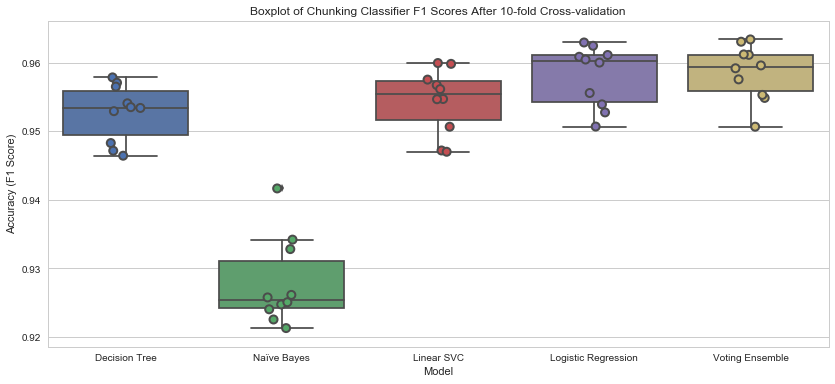

In [33]:
fig, ax = plt.subplots(figsize=(14,6)) 
f1_boxplot = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.title('Boxplot of Chunking Classifier F1 Scores After 10-fold Cross-validation')
plt.ylabel('Accuracy (F1 Score)')
plt.xlabel('Model')
plt.show()
fig = f1_boxplot.get_figure()
fig.savefig('Boxplot of Chunking Classifier F1 Scores.jpg', bbox_inches='tight')

In [19]:
print("Mean F1 Scores")
print(cv_df.groupby('model_name').accuracy.mean())
print("Standard Deviation")
print(cv_df.groupby('model_name').accuracy.std())

Mean F1 Scores
model_name
Decision Tree         0.95
Linear SVC            0.95
Logistic Regression   0.96
Naïve Bayes           0.93
Voting Ensemble       0.96
Name: accuracy, dtype: float64
Standard Deviation
model_name
Decision Tree         0.00
Linear SVC            0.00
Logistic Regression   0.00
Naïve Bayes           0.01
Voting Ensemble       0.00
Name: accuracy, dtype: float64


### VI. Compute a Classification Report and Confusion Matrix for the Best Classifier

The Voting Ensemble and Logistic Regression classifiers have the best performance after ten-fold cross-validation: a mean F1 score of 0.96 with a SD close to 0! The Voting Ensemble was chosen over the LR classifier because the boxplot reveals that the interquartile range of its accuracies is narrower, and because it incorporates the decisions and balances out the weaknesses of all four classifiers.

A classification report showing average accuracies from all ten folds of the VE is computed. There are three reported averages: micro (averaging the total true positives, false negatives, and false positives), macro (averaging the unweighted mean per label), and weighted (averaging the support-weighted mean per label). Macro average can be disregarded, as there is extreme class imbalance.

In [27]:
orig = []
pred = []

def cv_avg_classification_report(y_test, predicted_ve):
    orig.extend(y_test)
    pred.extend(predicted_ve)
    return metrics.f1_score(y_test, predicted_ve, average='weighted')

cross_val_score(clf_ve, X[:50000], y[:50000], cv=10, scoring=metrics.make_scorer(cv_avg_classification_report))
print(metrics.classification_report(orig, pred))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle

              precision    recall  f1-score   support

      B-ADJP       0.69      0.77      0.73       486
      B-ADVP       0.74      0.81      0.78      1046
     B-CONJP       0.33      0.50      0.40        14
      B-INTJ       0.33      0.25      0.29        12
       B-LST       1.00      0.75      0.86         4
        B-NP       0.98      0.97      0.97     13204
        B-PP       0.96      0.97      0.96      5072
       B-PRT       0.76      0.77      0.77       154
      B-SBAR       0.82      0.82      0.82       544
        B-VP       0.96      0.95      0.96      5267
      I-ADJP       0.94      0.91      0.93       150
      I-ADVP       0.74      0.78      0.76       115
     I-CONJP       0.95      0.95      0.95        19
      I-INTJ       1.00      1.00      1.00         2
        I-NP       0.98      0.97      0.98     14414
        I-PP       0.93      0.90      0.92        60
       I-PRT       0.00      0.00      0.00         2
      I-SBAR       1.00    

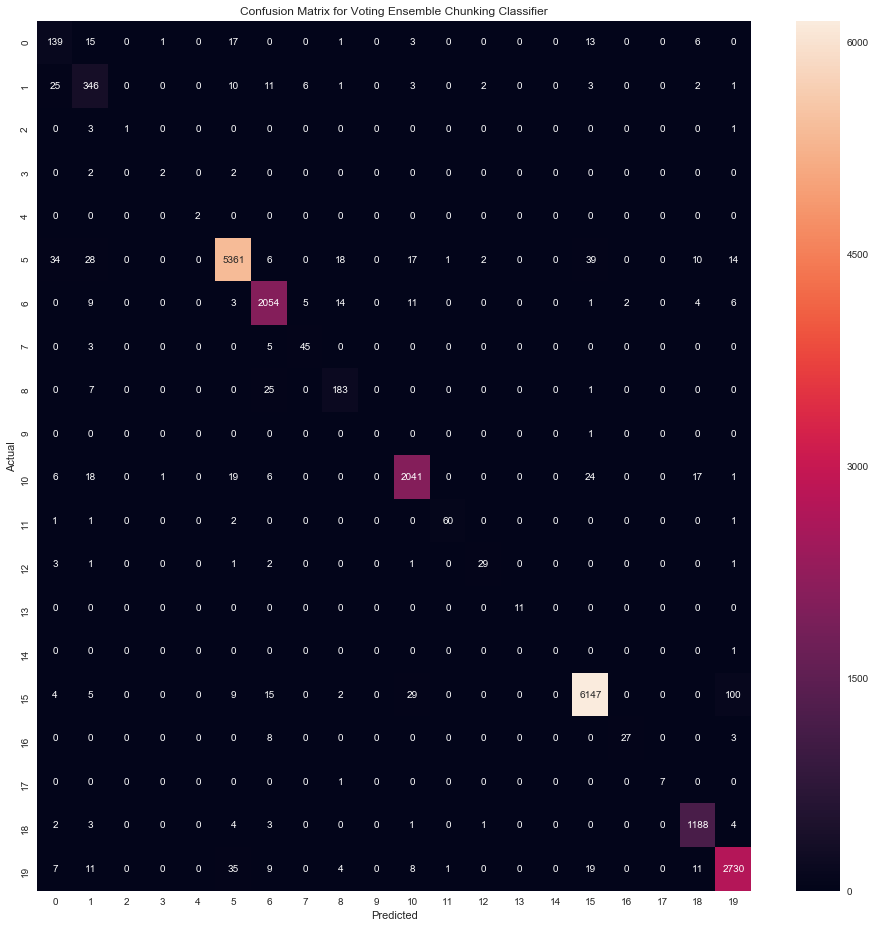

In [31]:
conf_mat = metrics.confusion_matrix(y_test, predicted_ve)
fig, ax = plt.subplots(figsize=(16,16))
conf_mat_heatmap = sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix for Voting Ensemble Chunking Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
fig = conf_mat_heatmap.get_figure()

### VII. Train and Save the Best Classifier

The Voting Ensemble classifier was trained on the full training dataset and saved as a pickle file. This was run on a remove server with 128 GB of RAM due to memory issues.

In [ ]:
clf_ve.fit(X, y)
save_classifier = open('chunking_clf_trained.pickle', 'wb') 
pickle.dump(clf_ve, save_classifier)
save_classifier.close()

In [13]:
saved_classifier = open('chunking_clf_trained.pickle', 'rb') 
chunking_clf_trained = pickle.load(saved_classifier)
saved_classifier.close()

Confirm that the classifier has been trained on all tweets: the F1 score is very close to 1, as it's been tested on training data.

In [14]:
predicted_ve_trained = chunking_clf_trained.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_ve_trained, average='weighted'))
print(metrics.classification_report(y_test, predicted_ve_trained))

Mean F1 score (weighted): 0.9870440622479951
              precision    recall  f1-score   support

      B-ADJP       0.86      1.00      0.93       195
      B-ADVP       0.86      0.97      0.91       410
     B-CONJP       0.83      1.00      0.91         5
      B-INTJ       1.00      0.83      0.91         6
       B-LST       0.67      1.00      0.80         2
        B-NP       0.99      0.99      0.99      5530
        B-PP       0.98      0.99      0.99      2109
       B-PRT       0.96      0.98      0.97        53
      B-SBAR       0.91      0.96      0.93       216
       B-UCP       1.00      1.00      1.00         1
        B-VP       0.99      0.99      0.99      2133
      I-ADJP       1.00      1.00      1.00        65
      I-ADVP       0.95      0.97      0.96        38
     I-CONJP       1.00      1.00      1.00        11
      I-INTJ       1.00      1.00      1.00         1
        I-NP       1.00      0.99      0.99      6311
        I-PP       0.97      0.97   

### VIII. Future Work/Model Refinement

The accuracies produced by these classifiers are extremely high, but they were trained on ground truth POS tags, so will necessarily be an overinflation of classifier performance on unlabelled text. 

**Other Classification Methods**

The classifiers tested here all have a fixed decision-making approach: the chunk labels that are made cannot be changed. An alternative approach suggested by the [NLTK book](https://www.nltk.org/book/ch06.html) is represented by **transformational joint classifiers**, which create initial label assignments that are iteratively refined if inconsistencies are found between related inputs. 

Another solution suggested by the book is assigning scores to all possible chunk sequences, and choosing the sequence with the highest overall score. This is represented by **Hidden Markov Models, Maximum Entropy Markov Models, and Linear-Chain Conditional Random Fields**. Rather than finding the single best tag for a given token, they generate a probability distribution over tags (i.e., they are probabilistic as opposed to deterministic). These probabilities are combined to calculate probability scores for tag sequences, and the tag sequence with the highest probability is chosen. To handle the enormous number of possible tag sequences, only the most recent tag is examined, and dynamic programming is used. For each consecutive token index i, a score is computed for each possible current and previous tag.

And of course, there is the deep learning approach. **Long short-term memory networks (LSTMs)**, a type of deep bi-directional RNNs, are well-suited for chunking because they take sequences into account. [Søgaard and Goldberg (2016)](http://anthology.aclweb.org/P16-2038) have used this model for a multi-task learning architecture that combines POS tagging, syntactic chunking, and Combinatory Category Grammar (CCG) supertagging. As these tasks share a 'lot of substructure', it makes sense for the models to share parameters. POS supervision is best at the innermost rather than the outermost layer, because POS tagging represents a lower level task that feeds into higher level tasks. PyTorch is a great library for [LSTMs and sequence models](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#lstm-s-in-pytorch).

**Qualitative Analysis of Misclassifications / Feature Engineering**

Misclassifications can be scrutinised to determine if there are any consistent patterns that the classifiers are overlooking. This information can, in turn, be used to refine feature engineering - arguably far more important than selecting sophisticated models.

This relates to *focussing on different chunk types*, which have different characteristics. It is most important to examine the chunk types that had the lowest F1 scores (this is detailed in the classification report), as improving accuracies for these chunks has the largest impact on overall accuracy. Are there certain characteristics of these chunk types not captured by feature engineering? Neither of the two instances of I-PRT was classified correctly, so its F1 score was 0.00. The next lowest chunk F1 scores are for B-INTJ (0.29) and B-CONJP (0.40). The low accuracies make sense, as these were among the least frequent tags in the dataset. 

**Memory / Out of Core Learning **

Fitting the classifiers requires a lot of memory. A more memory-effective solution would be to train by iterating over sections of the dataset at a time. Scikit-learn has incremental classifiers that learn from batches via the `partial_fit` method. It should be noted, however, that classifier accuracies improved only marginally (by about one percentage point) when trained on 90% of the training data vs. 25%.